In [203]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import plotnine as p9
import tensorflow_probability.substrates.jax.bijectors as tfb

import liesel_ptm as ptm

In [204]:
import optax
import tensorflow_probability.substrates.jax.distributions as tfd
from liesel.experimental.vi.builder import OptimizerBuilder
from liesel.experimental.vi.interface import LieselInterface

# from liesel.experimental.vi.optimizer import Optimizer
from liesel.experimental.vi.summary import Summary

In [205]:
from pathlib import Path

import dill as pickle

with open(Path.cwd() / ".." / "notebooks" / "y_ridge.pkl", "rb") as fp:
    y = pickle.load(fp)

In [206]:
y = jnp.r_[y, y, y, y, y, y, y, y, y, y]
y.shape

(1000,)

In [207]:
# y = tfd.Normal(loc=0.0, scale=1.0).sample((10000,), jax.random.key(1))
y = tfd.TwoPieceNormal(loc=0.0, scale=1.0, skewness=2.0).sample(
    (10000,), jax.random.key(1)
)

# y1 = tfd.Normal(loc=-2.0, scale=1.0).sample((1000,), jax.random.key(1))
# y2 = tfd.Normal(loc=2.0, scale=1.0).sample((1000,), jax.random.key(1))
# y = jnp.r_[y1, y2]

In [208]:
# y = jnp.r_[y,y]
# y.shape

In [209]:
nparam = 30
knots = ptm.OnionKnots(a=-7.0, b=7.0, nparam=nparam)

In [210]:
model = ptm.LocScalePTM(y, knots.knots, bspline="onion")
kernel_kwargs = {"da_target_accept": 0.9}
model.trafo += ptm.PTMCoef.new_rw1_fromzero(
    knots=knots.knots,
    scale=ptm.ScaleWeibull(
        0.2, scale=0.5, name="trafo0_scale", bijector=tfb.Exp(), clip_min=1e-15
    ),
    name="trafo0",
    diagonalize_penalty=True,
    noncentered=True,
)
model.build()

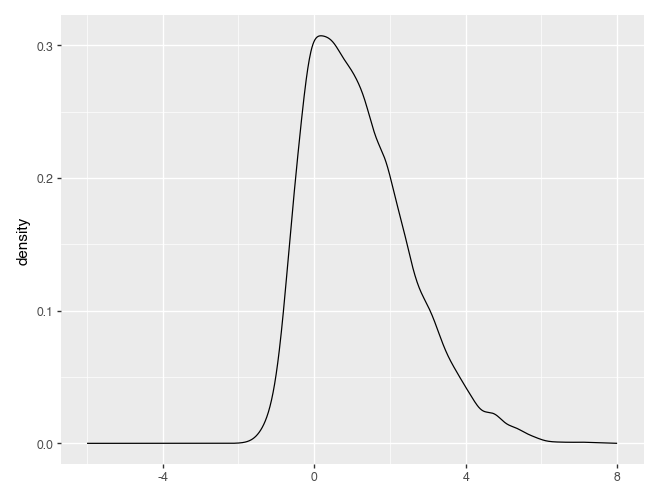

In [211]:
r_sample = model.response.value
(p9.ggplot() + p9.geom_density(p9.aes(r_sample)) + p9.xlim((-6.0, 8.0)))

In [212]:
r_sample.shape

(10000,)

/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_bin : Removed 13 rows containing non-finite values.


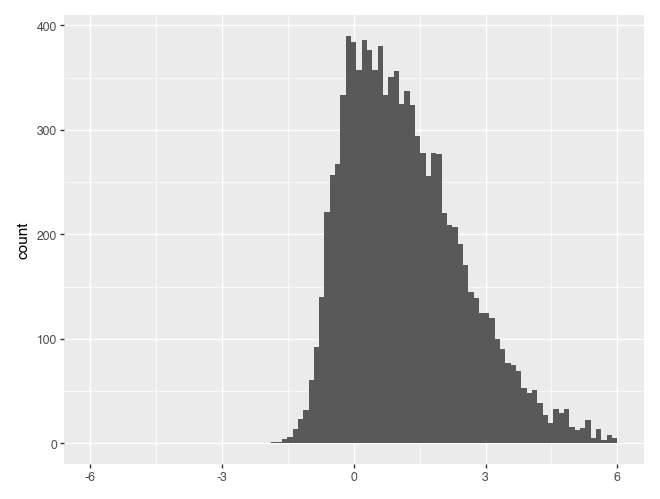

In [213]:
r_sample = model.response.value
(p9.ggplot() + p9.geom_histogram(p9.aes(r_sample), bins=100) + p9.xlim((-6.0, 6.0)))

In [214]:
# Initialize the builder.
builder = OptimizerBuilder(
    seed=123, n_epochs=10000, batch_size=256, S=32, window_size=150, patience_tol=1e-6
)

# Set up the model interface.
interface = LieselInterface(model.graph)
builder.set_model(interface)

In [215]:
nparam = model.graph.vars["trafo0_latent"].value.shape[-1]

In [216]:
0.0007 < 1e-6

False

Early stopping triggered at epoch:    334 with ELBO: -16524.8945 - Relative Improvement: 0.0011


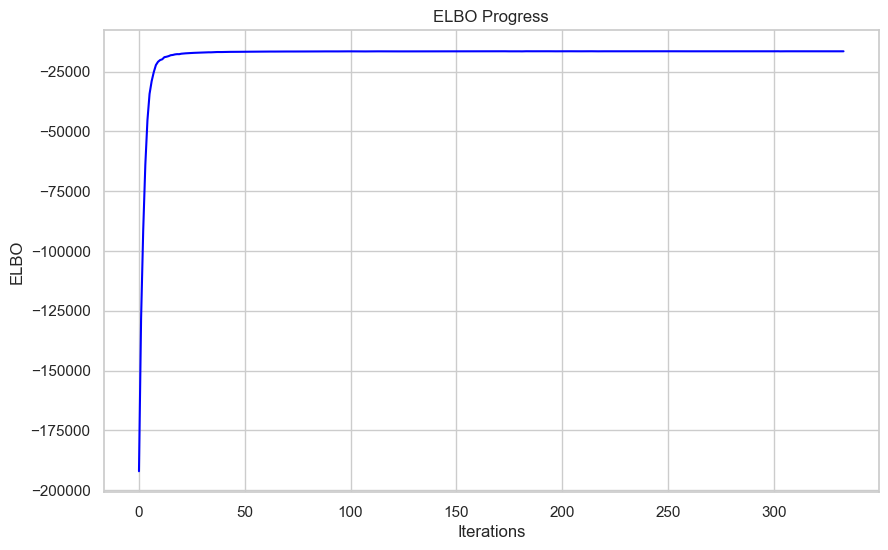

,variable,mean,variance,2.5%,97.5%,hdi_low,hdi_high
0,trafo0_latent[0],0.214218,0.824687,-1.652621,1.941448,-1.188366,1.701987
1,trafo0_latent[1],0.253501,1.001674,-1.646982,2.239068,-1.287150,1.934625
2,trafo0_latent[2],0.341496,0.808323,-1.317812,2.178903,-1.105147,1.780890
3,trafo0_latent[3],0.357663,0.768135,-1.346506,2.114655,-0.984177,1.823200
4,trafo0_latent[4],0.480489,0.902629,-1.354305,2.255557,-0.998324,2.140795
5,trafo0_latent[5],0.415650,0.866168,-1.291321,2.434332,-1.064091,1.917196
6,trafo0_latent[6],0.570247,0.842824,-1.245500,2.335869,-1.016101,2.011224
7,trafo0_latent[7],0.230400,0.912426,-1.667564,2.104835,-1.227579,1.822937
8,trafo0_latent[8],0.271900,0.882200,-1.501302,2.141865,-1.231143,1.740899
9,trafo0_latent[9],-0.257875,0.856021,-1.981493,1.598287,-1.795726,1.191536


In [217]:
# Define optimizer chains.
optimizer_chain1 = optax.adam(learning_rate=0.01)
optimizer_chain2 = optax.chain(
    optax.adam(learning_rate=0.01), optax.clip_by_global_norm(1.0)
)
# Add a univariate latent variable for sigma_sq.
# builder.add_variational_dist(
#     ["trafo0_scale_square_transformed"],
#     dist_class=tfd.Normal,
#     variational_params={"loc": 0.0, "scale": 0.5},
#     optimizer_chain=optimizer_chain1,
# )
# # Add a univariate latent variable for b.
# builder.add_variational_dist(
#     ["trafo0_latent", "trafo0_scale_square_transformed"],
#     dist_class=tfd.MultivariateNormalDiag,
#     variational_params={"loc": jnp.zeros(nparam+1), "scale_diag": jnp.ones(nparam+1)},
#     optimizer_chain=optimizer_chain2,
# )

builder.add_variational_dist(
    ["trafo0_latent", "trafo0_scale_square_transformed"],
    dist_class=tfd.MultivariateNormalTriL,
    variational_params={
        "loc": jnp.zeros(nparam + 1),
        "scale_tril": jnp.eye(nparam + 1),
    },
    optimizer_chain=optimizer_chain2,
)

# # Build and run the optimizer.
optimizer = builder.build()
optimizer.fit()

# Get results and compute summary.
results = optimizer.get_results(n_samples=1000, seed=4992)
summary = Summary(results)
summary.plot_elbo()
summary.compute_posterior_summary()

In [218]:
samples = results["samples"]
samples = jax.tree.map(lambda x: jnp.expand_dims(x, 0), samples)

In [219]:
dist = model.init_dist(samples, loc=0.0, scale=1.0)
rgrid = jnp.linspace(-6.0, 6.0, 301)
probs = jnp.exp(dist.log_prob(rgrid))
z = dist.transformation_and_logdet(rgrid)[0]

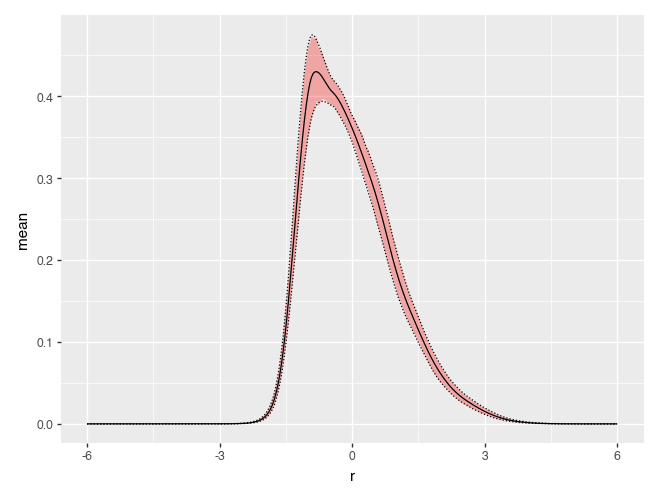

In [220]:
pdf_summary = gs.SamplesSummary({"pdf": probs}).to_dataframe().reset_index()
pdf_summary["r"] = rgrid

(
    p9.ggplot(pdf_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="red", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
)

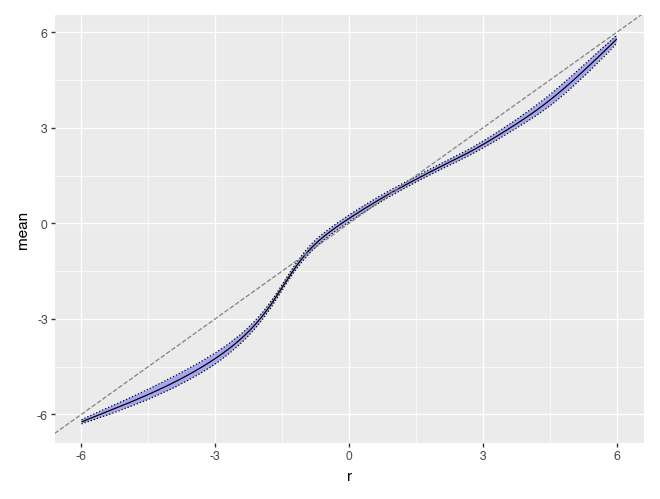

In [221]:
z_summary = gs.SamplesSummary({"z": z}).to_dataframe().reset_index()
z_summary["r"] = rgrid

(
    p9.ggplot(z_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="blue", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
    + p9.geom_abline(intercept=0.0, slope=1.0, linetype="dashed", color="grey")
)

In [222]:
pdf_samples = model.summarise_trafo_by_samples(
    jax.random.key(101), grid=rgrid, samples=samples
)
pdf_samples.head()

,z,cdf,pdf,index,obs,chain,sample,r
0,-6.217993,2.517775e-10,9.281155e-10,0,0,0,0,-6.00
1,-6.194943,2.915300e-10,1.062638e-09,1,1,0,0,-5.96
2,-6.172051,3.370497e-10,1.215970e-09,2,2,0,0,-5.92
3,-6.149313,3.890967e-10,1.390736e-09,3,3,0,0,-5.88
4,-6.126694,4.486195e-10,1.590165e-09,4,4,0,0,-5.84


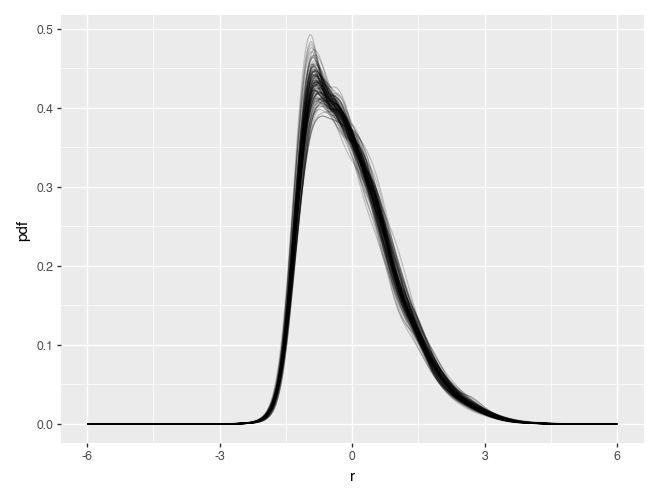

In [223]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "pdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

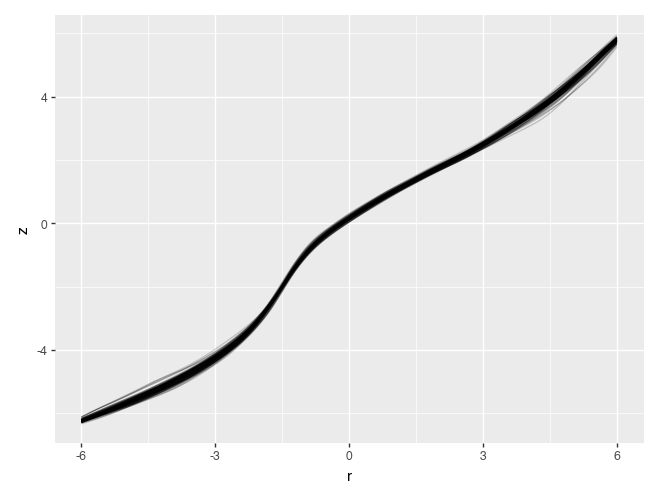

In [224]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "z")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

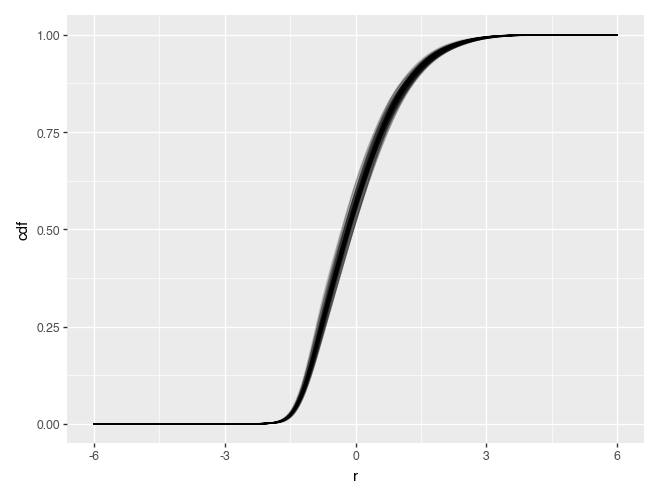

In [225]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "cdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)